In [1]:
#conda install openeo rioxarray geopandas leafmap h5netcdf netcdf4

In [1]:
from pathlib import Path
import json
import openeo
from shapely.geometry import shape
import geopandas as gpd
import matplotlib.pyplot as plt
import os 
from utils import extent_from_shp
import leafmap.foliumap as leafmap
import xarray as xr
from openeo.udf import execute_local_udf

/home/vpremier/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# set the working directory
wd = os.getcwd()
base_path = wd + os.sep + "results"

if not os.path.exists(base_path):
    os.mkdir(base_path)
base_path   

'/home/vpremier/Documents/openEO/results'

## Show the study area and get the bounding box
- Read a shapefile with the AOI
- Get the basin outline
- Show on the map


In [3]:
shp_path = r'/mnt/CEPH_PROJECTS/PROSNOW/research_activity/Senales/auxiliary/boundaries/SenalesCatchment/SenalesCatchment.shp'

catchment_outline = gpd.read_file(shp_path)

center = (float(catchment_outline.centroid.y), 
          float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=1)
m.add_vector(shp_path, layer_name="catchment")
m

In [4]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    10.728539
miny    46.647281
maxx    11.039333
maxy    46.796379
Name: 0, dtype: float64

In [5]:
#bbox = [10.728539, 46.647281, 11.039333, 46.796379]

## Authentication
- to the Copernicus Data Space Ecosystem https://openeo.dataspace.copernicus.eu/
- Vito backend https://openeo-dev.vito.be

In [6]:
eoconn = openeo.connect("https://openeo-dev.vito.be")
eoconn.authenticate_oidc()

eoconn.describe_account()

Visit https://aai.egi.eu/device?user_code=IHFA-JNAY 📋 to authenticate.

[###################################--] ✅ Authorized successfully

Authenticated using device code flow.


{'info': {'oidc_userinfo': {'eduperson_assurance': ['https://refeds.org/assurance/IAP/low',
    'https://aai.egi.eu/LoA#Substantial'],
   'eduperson_entitlement': ['urn:mace:egi.eu:group:vo.openeo.cloud:role=member#aai.egi.eu',
    'urn:mace:egi.eu:group:vo.openeo.cloud:role=vm_operator#aai.egi.eu'],
   'eduperson_scoped_affiliation': ['employee@eurac.edu', 'member@eurac.edu'],
   'email': 'valentina.premier@eurac.edu',
   'email_verified': True,
   'sub': 'b5345703744f82d43e36ecfbbe263186fb2556417bd8fe0054ae63476450f901@egi.eu',
   'voperson_verified_email': ['Valentina.Premier@eurac.edu']}},
 'name': 'Valentina.Premier@eurac.edu',
 'user_id': 'b5345703744f82d43e36ecfbbe263186fb2556417bd8fe0054ae63476450f901@egi.eu'}

In [28]:
#eoconn.list_processes(eoconn.list_processes(#)

Show the available collections

In [29]:
print(eoconn.list_collection_ids())

['MAPEO_WATER_TUR_V1', 'COP_DEM_EU_25M', 'ESA_WORLDCEREAL_ACTIVECROPLAND', 'ESA_WORLDCEREAL_IRRIGATION', 'ESA_WORLDCEREAL_TEMPORARYCROPS', 'ESA_WORLDCEREAL_WINTERCEREALS', 'ESA_WORLDCEREAL_MAIZE', 'ESA_WORLDCEREAL_SPRINGCEREALS', 'TEST_DMP', 'SENTINEL1_GRD_SIGMA0', 'S1_GRD_SIGMA0_ASCENDING', 'S1_GRD_SIGMA0_DESCENDING', 'SENTINEL3_SYNERGY_VG1', 'SENTINEL3_SYNERGY_VG10', 'TERRASCOPE_S2_FAPAR_V2', 'TERRASCOPE_S2_NDVI_V2', 'TERRASCOPE_S2_LAI_V2', 'TERRASCOPE_S2_FCOVER_V2', 'TERRASCOPE_S2_TOC_V2', 'TERRASCOPE_S1_SLC_COHERENCE_V1', 'SENTINEL1_GAMMA0_SENTINELHUB', 'SENTINEL1_GRD', 'SENTINEL2_L1C_SENTINELHUB', 'SENTINEL2_L2A_SENTINELHUB', 'SENTINEL2_L2A_MOSAIC_120', 'PROBAV_L3_S10_TOC_333M', 'PROBAV_L3_S5_TOC_100M', 'PROBAV_L3_S1_TOC_100M', 'PROBAV_L3_S1_TOC_333M', 'TERRASCOPE_S5P_L3_NO2_TD_V1', 'TERRASCOPE_S5P_L3_NO2_TM_V1', 'TERRASCOPE_S5P_L3_NO2_TY_V1', 'TERRASCOPE_S5P_L3_CO_TD_V1', 'TERRASCOPE_S5P_L3_CO_TM_V1', 'TERRASCOPE_S5P_L3_CO_TY_V1', 'TERRASCOPE_S5P_L3_NO2_TD', 'TERRASCOPE_S5P_L3_NO

Load the Copernicus fractional snow cover collection

In [30]:
scf = eoconn.load_collection(
    "FRACTIONAL_SNOW_COVER",
    spatial_extent  = {'west':bbox[0],
                       'east':bbox[2],
                       'south':bbox[1],
                       'north':bbox[3],
                       'crs':4326},
    temporal_extent=['2023-08-02','2023-08-15'],
    bands=["FSCTOC"]
)
scf
# scf.download(base_path + os.sep + 'scf_0.nc')

Load the MODIS SCF data (?)

In [31]:
#modis = eoconn.load_stac(url = 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/modis-10A1-061',
#                         spatial_extent = {"west":16.15,"east":16.2,"north":47.3,"south":47.25}, 
#                         temporal_extent=['2022-11-02','2022-11-03']                         temporal_extent=['2022-11-02','2022-11-03']`,
#                         bands=["NDSI_Snow_Cover"])
#modis.download(base_path +os.sep+ "modis.nc")

- Resample the datatset to the target crs and resolution.
- Apply filter_bbox to filter to a new extent (now set manually in order to have a grid that is exactly aligned with a 500 m specific grid). In the future -> resample_cube_spatial to resample it w.r.t. the MODIS collection (not available at the moment)

In [32]:
west=631910.
south=5167310.
east=655890.
north=5184290.
res = 20.

# check that the grid is aligned with a 500 m gri
print('Nr. of low-resolution pixels in the resampled grid (x): {}'.format((east + res/2. - (west - res/2. ))/500.))
print('Nr. of low-resolution pixels in the resampled grid (y): {}'.format((south - res/2. - (north + res/2. ))/-500.))

scf_rsmpl = scf.resample_spatial(resolution=res, 
                                 projection=32632,
                                 method = "cubic")

            
scf_bbox = scf_rsmpl.filter_bbox(west=west, 
                                 south=south, 
                                 east=east, 
                                 north=north, 
                                 crs=32632)
# scf_bbox.download(base_path + os.sep + 'scf_rsmp.nc')
scf_bbox

Nr. of low-resolution pixels in the resampled grid (x): 48.0
Nr. of low-resolution pixels in the resampled grid (y): 34.0


The Copernicus FSC needs to be converted to a binary map: snow (100) - snow free (0) and clouds/no data (205)

In [33]:
binarize = openeo.UDF.from_file('udf-binarize.py', 
                                context={"from_parameter": "context"})

scf_binary = scf_bbox.apply(process=binarize, 
                            context={"snowT": 20})

scf_binary_renamed = scf_binary.rename_labels(dimension="bands",
                                              target=["scf"])
# scf_binary.download(base_path + os.sep + 'scf_binary.nc')

# More elegant alternative: band math but problem with the unsigned bits
# scf_test = 100.0 * (scf >= 20) * (scf <= 100) + 205.0 * (scf == 205)
scf_binary

Example of apply_neighborhood (from https://open-eo.github.io/openeo-python-client/udf.html)
I want to do something similar.. downsampling the datacube and eventually update the cube metadata

In [34]:
udf_code = Path('udf_modify_spatial.py').read_text()

cube_updated = scf_binary.apply_neighborhood(
    lambda data: data.run_udf(udf=udf_code, runtime='Python-Jep', context=dict()),
    size=[
        {'dimension': 'x', 'value': 600, 'unit': 'px'},
        {'dimension': 'y', 'value': 425, 'unit': 'px'}
    ], overlap=[])

cube_updated.download(base_path + os.sep + 'scf_test2.nc')

OpenEoApiError: [500] Internal: Server error: Exception during Spark execution: org.apache.spark.SparkException: Job 2001 cancelled runaway job 2001 cancelled after PT15M (ref: r-2402207796aa4fe4935267b8ebe32c17)

Test. A very simple udf that should print out some DataCube features... When using apply, it works!

In [70]:
test = openeo.UDF.from_file('udf-test.py')
mytest = scf_binary.apply(process=test)

test_inspect = mytest.save_result(format='netCDF')
job = test_inspect.create_job(title='inspect')
job.start_job()

#job.status()

#mytest.download(base_path + os.sep + 'scf_test.nc')

<BatchJob job_id='j-24021318ec284b969ec52a77af5241d4'>

In [36]:
test = Path('udf-test.py').read_text()

mytest = scf_binary.apply_neighborhood(
    lambda data: data.run_udf(udf=test, 
                              runtime='Python-Jep', 
                              context=dict()),
    size=[
        {'dimension': 'x', 'value': 600, 'unit': 'px'},
        {'dimension': 'y', 'value': 500, 'unit': 'px'}
    ], overlap=[])
mytest.download(base_path + os.sep + 'scf_test2.nc')

OpenEoApiError: [500] Internal: Server error: Exception during Spark execution: java.lang.IllegalStateException: SpatialKeyPartitioner was used to partition non-spatial keys. (ref: r-2402125ce6824a63be2e7ebd478618ea)

Aggregate the S-2 pixels to the resolution of the MODIS to get a SCF

In [45]:
#execute the udf locally
path=r'/home/vpremier/Documents/openEO/results/scf_binary.nc'
array = xr.open_dataset(path,decode_coords="all")

aggregation = openeo.UDF.from_file('udf-scf-local.py', 
                                   context={"from_parameter": "context"})
output = execute_local_udf(aggregation, path, fmt='netcdf')

Coordinates:
  * t        (t) datetime64[ns] 2023-08-06 2023-08-11 2023-08-14
  * bands    (bands) object 'FSCTOC'


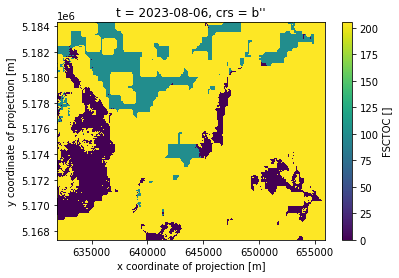

In [46]:
array.isel(t=0)['FSCTOC'].plot()

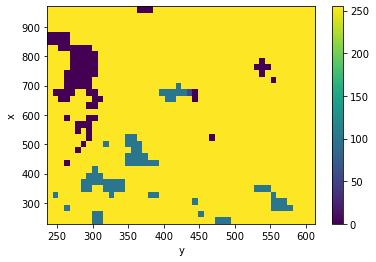

In [53]:
output.get_datacube_list()[0].get_array().plot()

In [55]:
# works but the result is wrong (probably due to the chunk size!)
aggregation = openeo.UDF.from_file('udf-scf.py', 
                                context={"from_parameter": "context"})

scf_aggregated = scf_binary.apply(process=aggregation, 
                                   context={"pixel_ratio": 25})
scf_aggregated.download(base_path + os.sep + 'scf_aggregated.nc')

In [ ]:
scf_aggregated_renamed = scf_aggregated.rename_labels(dimension="bands",
                                                      target=["aggregated"])
merged_cube = scf_binary_renamed.merge_cubes(scf_aggregated)

In [57]:
aggregation = Path('udf-scf.py').read_text()

scf_aggregated = scf_binary.apply_neighborhood(
    lambda data: data.run_udf(udf=aggregation, runtime='Python-Jep', 
                                   context={"pixel_ratio": 25}),
    size=[
        {'dimension': 'x', 'value': 600, 'unit': 'px'},
        {'dimension': 'y', 'value': 500, 'unit': 'px'}
    ], overlap=[])
scf_aggregated.download(base_path + os.sep + 'scf_aggregated2.nc')

OpenEoApiError: [401] TokenExchangeFailure: Authentication failed. Please login on our marketplace web https://portal.terrascope.be first, and then try authenticate again.

In [206]:
results = job.get_results()
results

<JobResults for job 'j-2311215d3c68441db3af7aa8b68b5697'>

Current issues:
- udf_test not working when using apply neighborhood
- udf of the example is not working
- my udf is not working